In [1]:
import keras
import tensorflow as tf
import vis ## keras-vis
import matplotlib.pyplot as plt
import numpy as np
print("keras      {}".format(keras.__version__))
print("tensorflow {}".format(tf.__version__))

Using TensorFlow backend.


keras      2.2.2
tensorflow 1.10.0


In [2]:
from keras.applications.vgg16 import VGG16, preprocess_input
model = VGG16(weights='imagenet')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [3]:
import json
CLASS_INDEX = json.load(open("imagenet_class_index.json"))
classlabel = []
for i_dict in range(len(CLASS_INDEX)):
    classlabel.append(CLASS_INDEX[str(i_dict)][1])
print("N of class={}".format(len(classlabel)))

N of class=1000


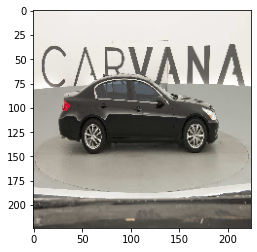

In [23]:
from keras.preprocessing.image import load_img, img_to_array
_img = load_img('../train/11f3dc041cfb_13.jpg',target_size=(224,224))
plt.imshow(_img)

In [24]:
img               = img_to_array(_img)
img               = preprocess_input(img)
y_pred            = model.predict(img[np.newaxis,...])
class_idxs_sorted = np.argsort(y_pred.flatten())[::-1]
topNclass         = 5
for i, idx in enumerate(class_idxs_sorted[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.3f}".format(
          i + 1,classlabel[idx],idx,y_pred[0,idx]))

Top 1 predicted class:     Pr(Class=convertible        [index=511])=8.934
Top 2 predicted class:     Pr(Class=minivan            [index=656])=8.892
Top 3 predicted class:     Pr(Class=tow_truck          [index=864])=8.849
Top 4 predicted class:     Pr(Class=limousine          [index=627])=8.365
Top 5 predicted class:     Pr(Class=racer              [index=751])=7.870


In [15]:
from vis.utils import utils
# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
layer_idx = utils.find_layer_idx(model, 'predictions')

In [16]:
# Swap softmax with linear
model.layers[layer_idx].activation = keras.activations.linear
model = utils.apply_modifications(model)

/home/usman/.virtualenvs/tf1/lib/python3.6/site-packages/keras/engine/saving.py:269: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [25]:
from vis.visualization import visualize_saliency
class_idx = class_idxs_sorted[0]
grad_top1 = visualize_saliency(model,
                               layer_idx,
                               filter_indices = class_idx,
                               seed_input     = img[np.newaxis,...])

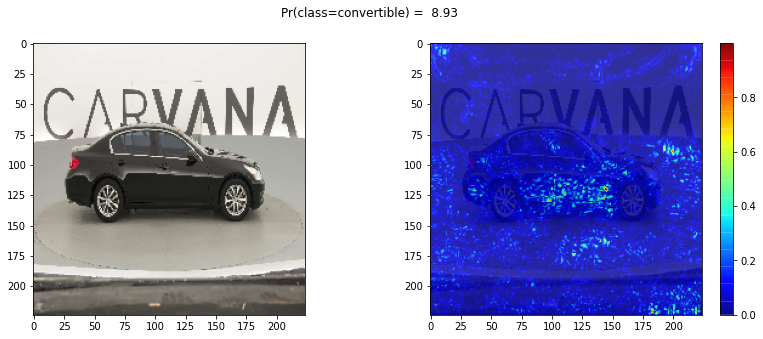

In [26]:
def plot_map(grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(_img)
    axes[1].imshow(_img)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.8)
    fig.colorbar(i)
    plt.suptitle("Pr(class={}) = {:5.2f}".format(
                      classlabel[class_idx],
                      y_pred[0,class_idx]))
plot_map(grad_top1)

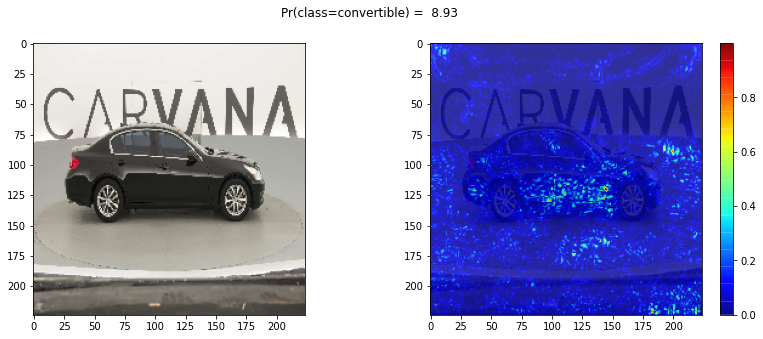

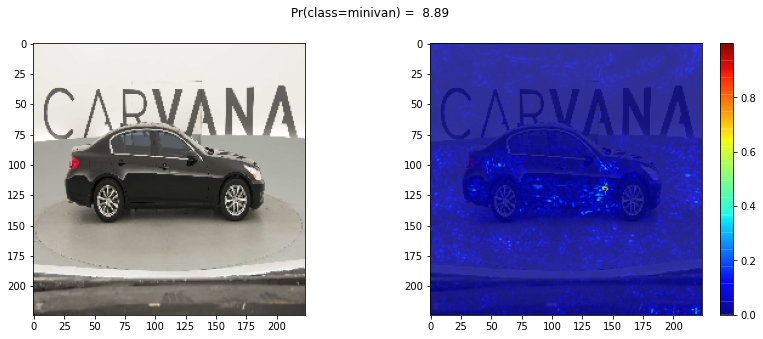

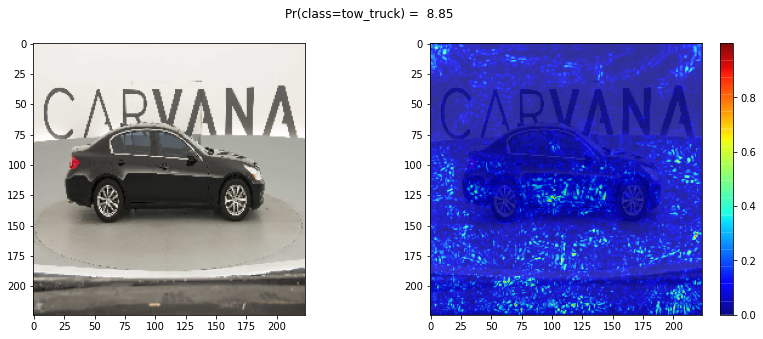

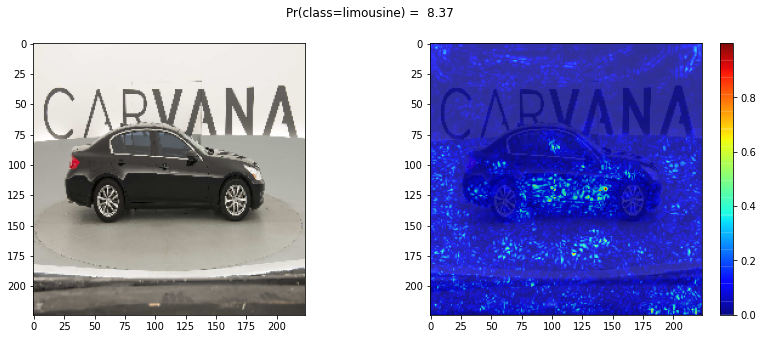

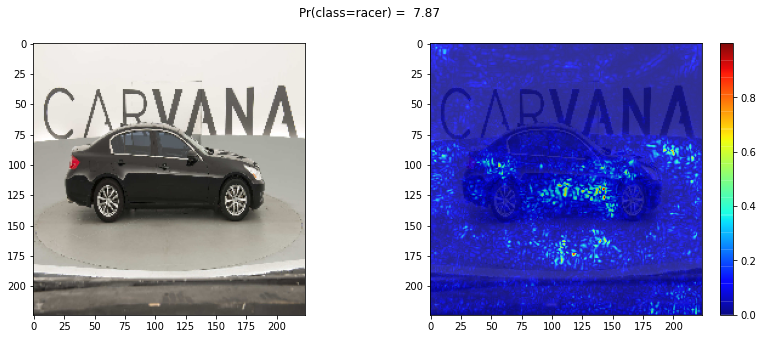

In [27]:
for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_saliency(model,
                               layer_idx,
                               filter_indices = class_idx,
                               seed_input     = img[np.newaxis,...])
    plot_map(grads)